In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

## 데이터 전처리

In [7]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [8]:
train_x = train_x.astype('float32')
train_x = (train_x - 127.5) / 127.5 

print("max pixel:", np.amax(train_x))
print("min pixel:", np.amin(train_x))

max pixel: 1.0
min pixel: -1.0


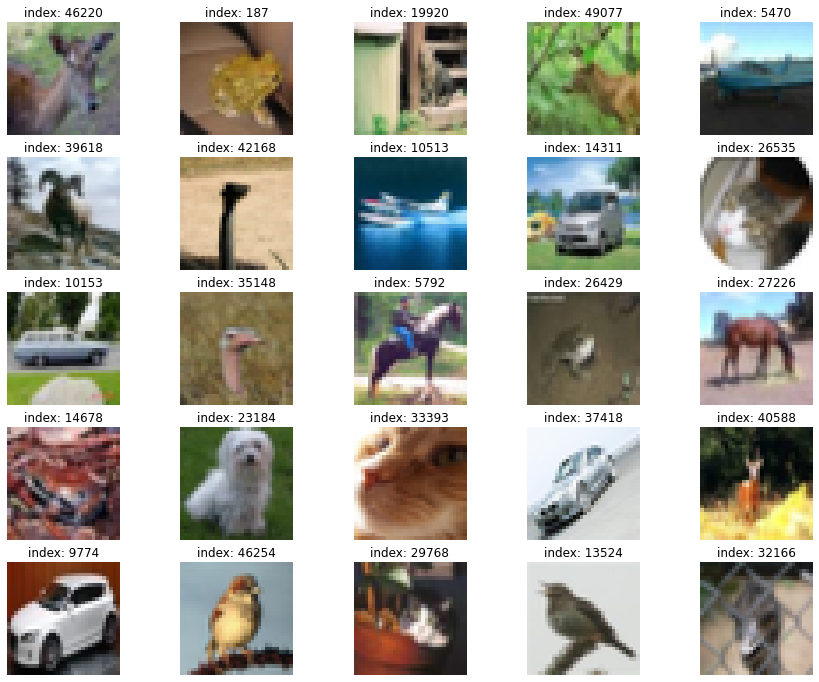

In [9]:
plt.figure(figsize=(15, 12))

for i in range(25):
    rn = np.random.randint(train_x.shape[0])
    plt.subplot(5, 5, i+1)
    Image = np.clip(train_x[rn], 0, 1)
#     plt.imshow(Image.reshape(32, 32, 3))
    plt.imshow((train_x[rn] + 1)/2.0)
    plt.title(f'index: {rn}')
    plt.axis('off')
    
plt.show()

In [10]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 생성자 구현하기

In [11]:
def make_generator_model(momentum=0.9, alpha=0.2):
    dropout = 0.4
    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))
    
    model.add(layers.Reshape(( 4, 4, 512)))
    model.add(layers.Dropout(dropout))
    # First Layer
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)
    return model

In [12]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              819200    
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3276800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1

In [13]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

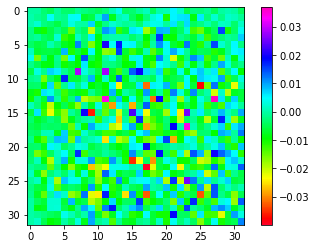

In [14]:
plt.imshow(generated_image[0, :, :, 0], cmap ='gist_rainbow')
plt.colorbar()
plt.show()

## 판별자 구현하기

In [15]:
def make_discriminator_model(alpha=0.2):
    dropout = 0.4
    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(dropout))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(dropout))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [16]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 128)       9728      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)            

In [17]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00154677]], dtype=float32)>

## 손실함수와 최적화함수 구현하기

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 손실 함수

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [19]:
# 최적화 함수

generator_optimizer = tf.keras.optimizers.Adam(4e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(8e-4, beta_1=0.5)

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 훈련과정 설계

In [20]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [21]:
# 예측 이미지를 파일에 저장
# gif 파일 생성을 위함
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] + 1)/2.0)
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [22]:
# training_history 생성
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [23]:
# 체크 포인트 만들기
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 학습 시키기

In [24]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [37]:
save_every = 5
EPOCHS = 100

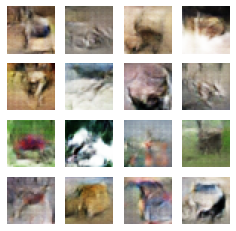

Time for training : 2579 sec


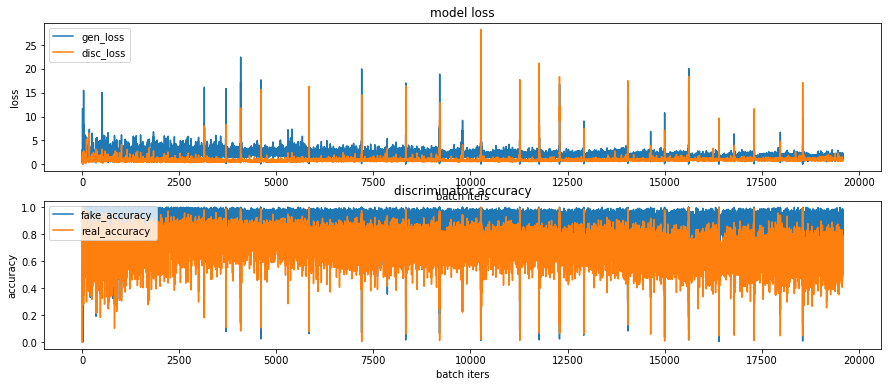

CPU times: user 43min 44s, sys: 33.3 s, total: 44min 17s
Wall time: 43min


In [38]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

## 추가 학습

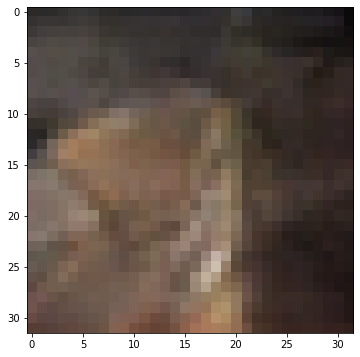

In [25]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [28]:
save_every = 5
EPOCHS = 50

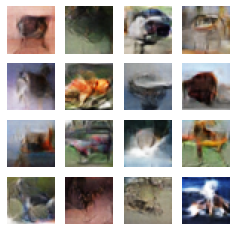

Time for training : 1356 sec


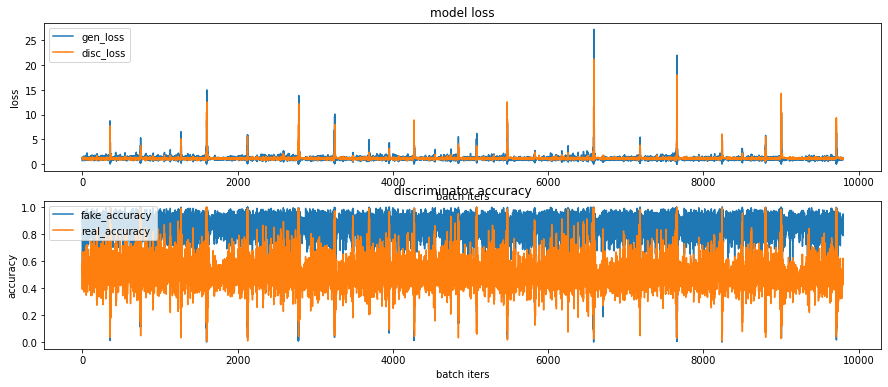

CPU times: user 22min 26s, sys: 12.5 s, total: 22min 38s
Wall time: 22min 37s


In [29]:
%%time
train(train_dataset, EPOCHS, save_every)

## Gif 만들기

In [32]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/second.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 aiffel0042 aiffel0042 1294516 10월  5 17:29 /home/aiffel0042/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


In [33]:
os.rename(anim_file, './data/gif/175-225.gif.png')

## Report

### 첫번째 시도

초기에 적용한 하이퍼파라미터는 다음과 같다.

- noise_dim = 100
- learning_rate = 1e-4 (generator)
- learning_rate = 1e-4 (discriminator)
- batch_size = 256
- epochs = 100
- alpha = 0.3 (leaky ReLU)
- beta_1 = 0.9 (AdamOptimizer)
- momentum = 0.99 (BatchNormalization)

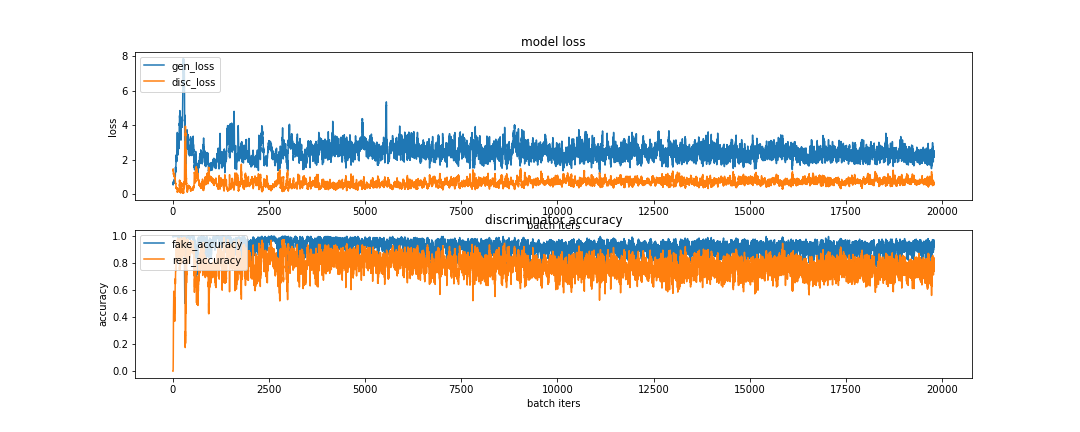

In [44]:
display.Image(filename="./data/img/first_train_history.png")

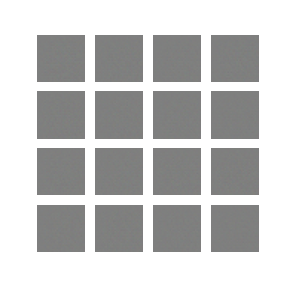

In [31]:
display.Image(filename="./data/gif/first.gif.png")

gen_loss는 2, disc_loss는 1에 가깝게 나타나고 있다. 그리고 Accuracy(fake_accuracy)가 계속 1에 가깝게 유지되고 있으므로 아직 제대로 속이고 있지 못하고 있다. gif파일을 보면 epoch을 100으로 돌려본 결과 아직 제대로된 형태가 나오지 않고 있다.

### 두번째 시도

적용한 하이퍼파라미터는 다음과 같다. 진하게 체크된 파라미터를 변경했다

- noise_dim = 100
- **learning_rate = 4e-4 (generator)**
- **learning_rate = 8e-4 (discriminator)**
- batch_size = 256
- epochs = 100
- **alpha = 0.2 (leaky ReLU)**
- **beta_1 = 0.5 (AdamOptimizer)**
- **momentum = 0.9 (BatchNormalization)**
- **generator에 dropout 추가**

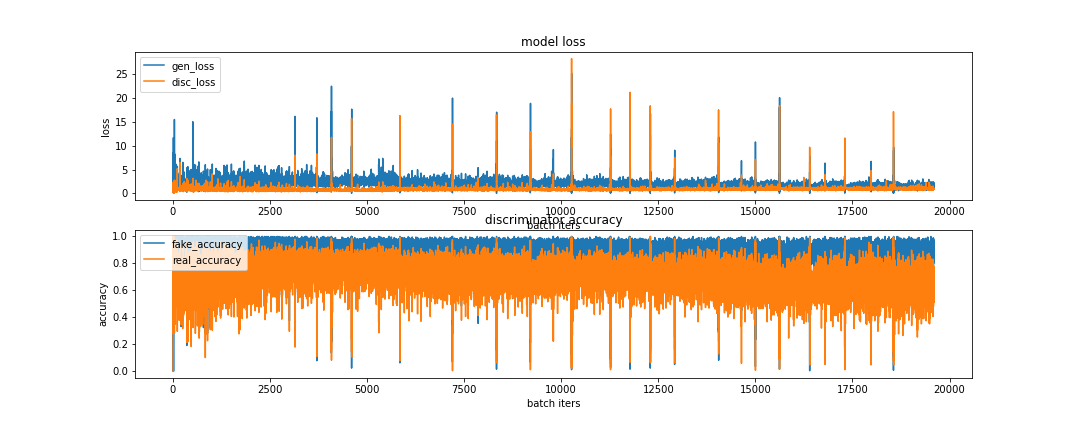

In [45]:
display.Image(filename="./data/img/second_train_history.png")

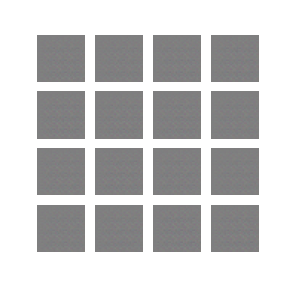

In [43]:
display.Image(filename="./data/gif/second.gif.png")

history 그래프가 들쑥날쑥 하지만 안정적으로 loss가 줄어드는 모습을 볼 수 있다. 그리고 real_accuracy가 점점 0.5에 수렴하고 있음을 알 수 있다. 결론적으로 학습이 잘 되고 있다는 지표이다.  
gif 이미지를 봐도 첫번째 시도 보다 눈에 띄게 좋아졌다. 좀 더 선명한 이미지를 얻기 위해서 추가 학습을 실행해보았다.

### 추가학습

#### 100-175 epochs

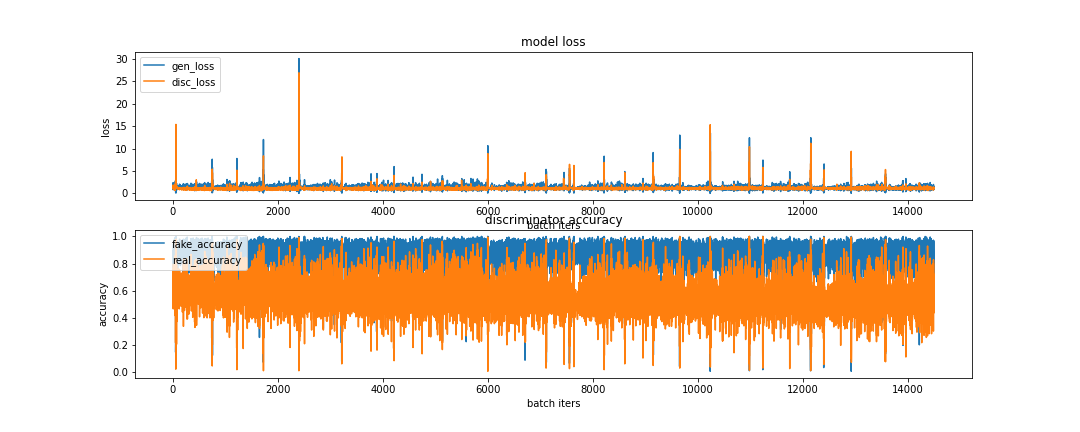

In [30]:
display.Image(filename="./data/img/train_history_100-175.png")

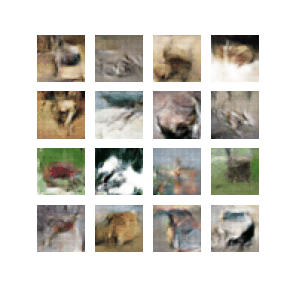

In [40]:
display.Image(filename="./data/gif/100-175.gif.png")

추가로 75번을 더 훈련시켰더니 좀더 괜찮은 형태를 갖추기 시작했다. 하이퍼파라미터를 튜닝하는게 얼마나 학습결과에 영향을 미치는지 알게 되었다. 위의 그래프에서 real_accuracy는 점점 0.5로 향하고 있다. fake_accuracy도 미세하게 내려가고 있지만, 눈에 띄게 좋아지지 않아서 아쉬움이 있다.

#### 175-225 epochs

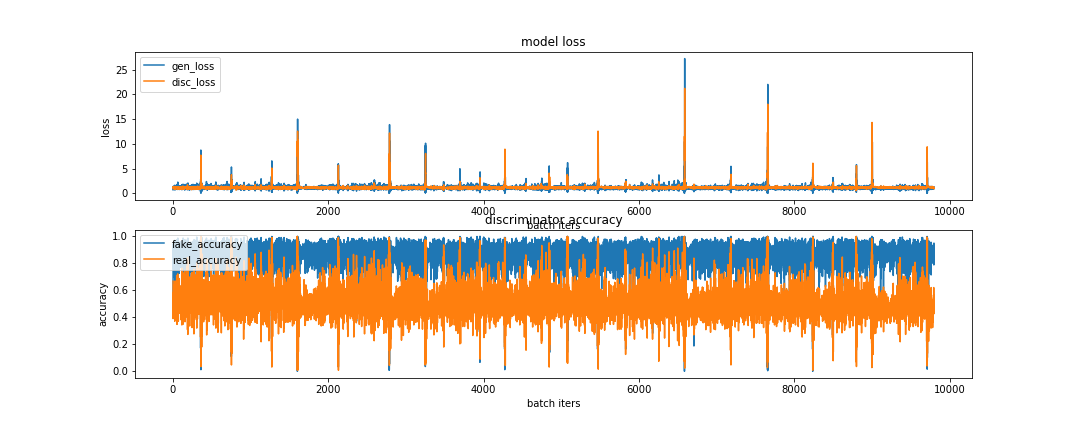

In [31]:
display.Image(filename="./data/img/train_history_175-225.png")

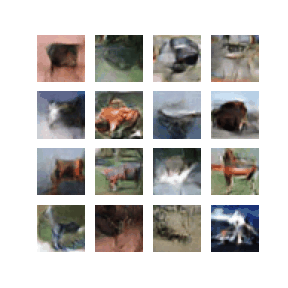

In [34]:
display.Image(filename="./data/gif/175-225.gif.png")

고정되어 있는 seed가 아니기 때문에 Kernel을 Restart하니 이미지가 달라졌다. 하지만 앞서 진행한 check_point 파일을 불러왔으므로 성능 체크에는 문제가 없을 것이다. 다양한 하이퍼파라미터 setting을 해서 성능을 높여보고 싶지만, 이번에는 여기서 마치도록 하겠다. 

#### 최종

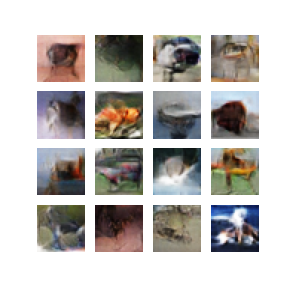

In [39]:
display.Image(filename="./data/img/final_img.png",  width=500, height=500)

최종 이미지를 보았을 때 구체적인 형태를 갖추고 있지 않지만 cifar 이미지와 유사한 형태를 갖추고 있다. 좀 더 괜찮은 하이퍼파라미터 조합을 가지고 있다면 더 나은 성능을 기대할 수 있을 것이다.